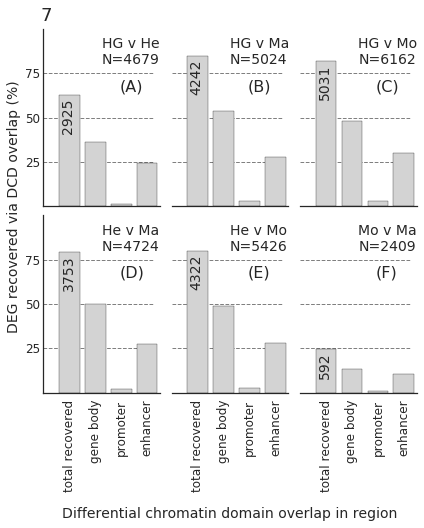

In [1]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js
import string as string

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot bar charts of DE genes
# that can be recovered with
# HSP overlaps

date = '20180725'

run_gene_recov_bars = True

save_figures = True
diss_version = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'isect_gene_hsp')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'

def extract_gene_table_header(fpath):
    """
    """
    hsp_header = 'chrom chromStart chromEnd name nat_score segment_expect segment_pv nat_score_lnorm group1 group2'.split()
    hsp_header = ['hsp_' + h for h in hsp_header]
    hsp_header += ['overlap']
    with open(fpath, 'r') as table:
        hd = table.readline().strip('#').strip().split('\t')
        hd = ['gene_' + h for h in hd]
    joint_header = hd + hsp_header
    return joint_header


def extract_enh_table_header(fpath):
    """
    """
    enh_header = 'regtype chrom chromStart chromEnd name score strand symbol'.split()
    enh_header = ['enh_' + h for h in enh_header]
    enh_header = ['regtype'] + enh_header + ['overlap']
    with open(fpath, 'r') as table:
        hd = table.readline().strip('#').strip().split('\t')
        hd = ['hsp_' + h in hd]
    joint_header = hd + enh_header
    return joint_header


def read_gene_overlap_table(fpath, header=None):
    """
    """
    if header is None:
        header = extract_gene_table_header(fpath)
    df = pd.read_csv(fpath, skiprows=1, header=None,
                     names=header, delimiter='\t')
    df = df.loc[df['gene_is_de'] > 0, :].copy()
    
    total_de = df['gene_name'].unique().size
    deg_names = df['gene_name'].unique()
    deg_hsp_hit = df.loc[df['overlap'] > 0, 'gene_name'].unique().size
    deg_hsp_hit_names = df.loc[df['overlap'] > 0, 'gene_name'].unique()
    infos = {'total': int(total_de), 'total_names': set(deg_names),
             'hits': int(deg_hsp_hit), 'hit_names': set(deg_hsp_hit_names)}
    return infos, header


def read_enh_overlap_table(fpath):
    """
    """
    hit_genes = set()
    regtype_idx = 10
    gene_name_idx = 17
    with open(fpath, 'r') as table:
        _ = table.readline()
        for line in table:
            if line.strip():
                columns = line.strip().split('\t')
                if columns[regtype_idx] == 'GENEHANCER':
                    ensid = columns[gene_name_idx]
                    assert ensid.startswith('ENSG'), 'Unrecognized identifier: {}'.format(line.strip())
                    hit_genes.add(ensid)
    return hit_genes


def get_partner_file(fpath, which):
    """
    """
    if which == 'promoter':
        ppath = os.path.dirname(fpath).replace('/isect_gene_hsp', '/isect_prom_hsp')
        pname = os.path.basename(fpath).replace('gene_', 'prom_')
        partner = os.path.join(ppath, pname)
        assert os.path.isfile(partner), 'Created invalid path to partner file: {}'.format(partner)
    elif which == 'enhancer':
        ppath = os.path.dirname(fpath).replace('/isect_gene_hsp', '/isect_hsp_any')
        pname = os.path.basename(fpath).replace('gene_ovl_hsp', 'hsp_ovl_reg')
        partner = os.path.join(ppath, pname)
        assert os.path.isfile(partner), 'Created invalid path to partner file: {}'.format(partner)
    else:
        raise ValueError('Unexpected partner requested: {}'.format(which))
    return partner        


def cache_gene_recovery(cache_file, gene_hsp_ovl):
    """
    """
    gene_header = None
    caching = dict()
    for gene_ovl in sorted(os.listdir(gene_hsp_ovl)):
        if not gene_ovl.endswith('.tsv'):
            continue
        # gene_ovl_hsp_ecs18_He_vs_Ma_ordem.tsv
        parts = gene_ovl.split('.')[0].split('_')
        seg = parts[3]
        c1, c2 = parts[4], parts[6]
        scoring = parts[7]
        comp = c1 + '_vs_' + c2
        fpath = os.path.join(gene_hsp_ovl, gene_ovl)
        infos, gene_header = read_gene_overlap_table(fpath, gene_header)
        body_hit_names = infos['hit_names']
        total_names = infos['total_names']
        collector = {'total_deg': infos['total'], 'deg_names': infos['total_names'],
                     'body_hits': infos['hits'], 'body_hit_names': infos['hit_names']}
        
        prom_partner = get_partner_file(fpath, 'promoter')
        infos, gene_header = read_gene_overlap_table(prom_partner, gene_header)
        uniq_prom = infos['hit_names'] - body_hit_names
        collector['prom_hits'] = len(uniq_prom)
        collector['prom_hit_names'] = uniq_prom
        
        body_hit_names = body_hit_names.union(uniq_prom)
        
        enh_partner = get_partner_file(fpath, 'enhancer')
        enh_hit_names = read_enh_overlap_table(enh_partner)
        # reduce to genes that are indeed DE
        enh_hit_names = enh_hit_names.intersection(total_names)
        uniq_enh = enh_hit_names - body_hit_names
        collector['enh_hits'] = len(uniq_enh)
        collector['enh_hit_names'] = uniq_enh
        collector['recov_deg'] = collector['body_hits'] + collector['prom_hits'] + collector['enh_hits']
        
        caching[(seg, scoring, comp)] = collector
        
    with open(cache_file, 'wb') as cache:
        pck.dump(caching, cache)
            
    return cache_file


def plot_recov_bars(dataset, fkey, save_diss):
    """
    """
    comparisons = sorted(dataset.keys())
    assert len(comparisons) == 6, '.....'
        
    ncols = 3
    nrows = 2
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=nrows, ncols=ncols,
                             sharex=False, sharey=False)
    
    plt.subplots_adjust(hspace=0.05, wspace=0.1)
    
    bar_heights = ['recov_deg', 'body_hits', 'prom_hits', 'enh_hits']
    sub_panel = {i: c for i, c in zip(range(len(comparisons)), string.ascii_uppercase)}
    
    for comp_idx, (row, col) in enumerate(itt.product([0, 1], [0, 1, 2])):
        ax = axes[row, col]

        comp = comparisons[comp_idx]
        panel = sub_panel[comp_idx]
        sub = dataset[comp]

        total_gene = sub['total_deg']
        yticks = [0.25, 0.5, 0.75]
        yticklabels = ['25', '50', '75']

        ax.set_ylim(0, 1)
        ax.set_xlim(0, 4.5)

        data_x = np.arange(1,5,1)
        data_y = np.array([sub[x] for x in bar_heights], dtype=np.float32)
        data_y = data_y / total_gene

        bars = ax.bar(data_x, data_y, align='center',
                      color='lightgrey', edgecolor='black')

        label = ' v '.join(comp.split('_vs_')) + '\nN={}'.format(total_gene)
        ax.text(0.5, 0.8, s=label,
                fontdict={'fontsize': 14},
                transform=ax.transAxes)
        ax.text(0.65, 0.65, s='({})'.format(panel),
                fontdict={'fontsize': 16},
                transform=ax.transAxes)

        for b in bars:
            x = b.get_x()
            if x == 0.6:
                ht = b.get_height()
                b_label = sub['recov_deg']
                ax.text(0.7, ht - 0.08,
                        b_label, fontdict={'fontsize': 14},
                        rotation=90)
       

        if col == 0:
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels, fontsize=12)
            ax.tick_params(axis='y', which='major', pad=3)
        else:
            ax.set_yticks([])

        for y in yticks:
            ax.axhline(y, 0, 0.95, ls='dashed', lw=1, color='grey', zorder=0)

        if row == 1:
            ax.set_xticks(data_x)
            ax.set_xticklabels(['total recovered', 'gene body', 'promoter', 'enhancer'],
                                rotation=90, fontsize=12)
        else:
            ax.set_xticks([])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if col != 0:
            ax.spines['left'].set_visible(False)

        if row == 0 and col == 0:
            yl = ax.set_ylabel('DEG recovered via DCD overlap (%)', fontsize=14)
            yl.set_position((-0.25, 0.))
            
            if not save_diss:
                tt = ax.set_title(fkey, fontsize=18)
                tt.set_position((0.025, 1.01))

        if row == 1 and col == 1:
            xl = ax.set_xlabel('Differential chromatin domain overlap in region',
                               fontsize=14, labelpad=15, zorder=3)

    return fig, []


def plot_gene_recovery_barchart():
    cache_file = os.path.join(cache_dir, '{}_plot_gene_recov_hsp.pck'.format(date))
    if (not os.path.isfile(cache_file)) or os.stat(cache_file).st_size < 10:
        print('Caching')
        _ = cache_gene_recovery(cache_file, isect_root)

    with open(cache_file, 'rb') as cache:
        counts = pck.load(cache)
        
    plot_data = dict()
    seg = 'cmm18'
    score = 'penem'
    for k, v in counts.items():
        if seg == k[0] and score == k[1]:
            if k[2] == 'Liver_vs_Blood':
                continue
            plot_data[k[2]] = v

    fk = '7'
    fig, exart = plot_recov_bars(plot_data, fk, diss_version)

    if save_figures:
        outname = 'fig_{}_gene_recov_bars_{}_{}'.format(fk, seg, score)
        out_folder = fig_main
        if diss_version:
            out_folder = fig_diss

        out_pdf = os.path.join(out_folder, outname + '.pdf')
        fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
        
        if not diss_version:
            out_png = os.path.join(out_folder, outname + '.png')
            fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
    return



if run_gene_recov_bars:
    plot_gene_recovery_barchart()
